Download example vectors from https://github.com/erikbern/ann-benchmarks

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import mkl

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["OMP_NUM_THREADS"] = "6"
os.environ["MKL_NUM_THREADS"] = "6"
os.environ["OPENBLAS_NUM_THREADS"] = "6"

mkl.set_num_threads(6)

6

In [3]:
import h5py
import numpy as np
data = h5py.File('deep-image-96-angular.hdf5', 'r')

In [4]:
def normalize(x):
    return x / (np.linalg.norm(x, axis=1).reshape(-1, 1) + 1e-5)

train_embeddings = data['train'][:]
test_embeddings = data['test'][:]
exact_indices = data['neighbors'][:, 0]

train_embeddings = normalize(train_embeddings)
test_embeddings = normalize(test_embeddings)

In [5]:
d = test_embeddings.shape[1]
d, train_embeddings.shape, test_embeddings.shape

(96, (9990000, 96), (10000, 96))

# Build index

In [6]:
nlist = 2 * int(np.sqrt(train_embeddings.shape[0]))
nlist

6320

In [7]:
from fast_ivf import FastIVF

index = FastIVF(d, nlist=nlist, kmeans_batch_size=1024, kmeans_max_steps=2000)
index.train(train_embeddings)

Convergence delta = 0.00027: 100%|██████████| 2000/2000 [00:27<00:00, 71.71it/s]
Assigning: 9756it [00:45, 213.45it/s]                          


Text(0, 0.5, 'Count')

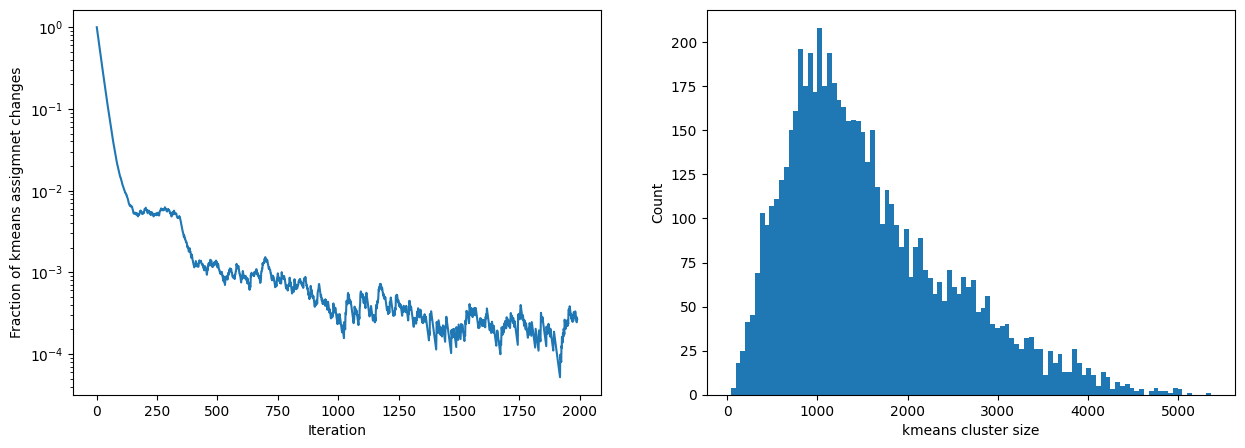

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(index.kmeans._history)
plt.xlabel("Iteration")
plt.ylabel("Fraction of kmeans assigmnet changes")
plt.yscale("log")
plt.subplot(1, 2, 2)
indices, counts = np.unique(index.kmeans._labels, return_counts=True)
plt.hist(counts, 100);
plt.xlabel("kmeans cluster size")
plt.ylabel("Count")

# Evaluate index

In [9]:
index.nprobe = 1
index.search(test_embeddings[:1], k=100);

In [10]:
index.nprobe = 10
index.ratio_threshold = 0.5
distances, indices = index.search(test_embeddings, k=100)

accuracies = []
for i, qi in enumerate(indices):
    acc = exact_indices[i] in qi[:10]
    accuracies.append(acc)
np.mean(accuracies)

0.8811

In [11]:
%timeit index.search(test_embeddings, k=100)

1.64 s ± 31.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Compare with Faiss IVF Index

In [12]:
import faiss

quantizer = faiss.IndexFlatIP(d)
faiss_index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)
faiss_index.train(train_embeddings)
faiss_index.add(train_embeddings)

In [13]:
faiss_index.nprobe = 10
distances, indices = faiss_index.search(test_embeddings, 100)

accuracies = []
for i, qi in enumerate(indices):
    acc = exact_indices[i] in qi[:10]
    accuracies.append(acc)
np.mean(accuracies)

0.8874

In [14]:
%timeit faiss_index.search(test_embeddings, 100)

1.73 s ± 16.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
from collections import defaultdict
from tqdm import tqdm


faiss_centroids = faiss_index.quantizer.reconstruct_n(0, nlist)
faiss_assignments = []
for batch in tqdm(np.split(train_embeddings, 100)):
    faiss_assignments += [np.argmax(batch @ faiss_centroids.T, axis=-1)]

faiss_assignments = np.concatenate(faiss_assignments)
faiss_clusters = defaultdict(list)
for i, c in enumerate(faiss_assignments):
    faiss_clusters[c].append(i)

indices, faiss_counts = np.unique(faiss_assignments, return_counts=True)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:30<00:00,  1.10it/s]


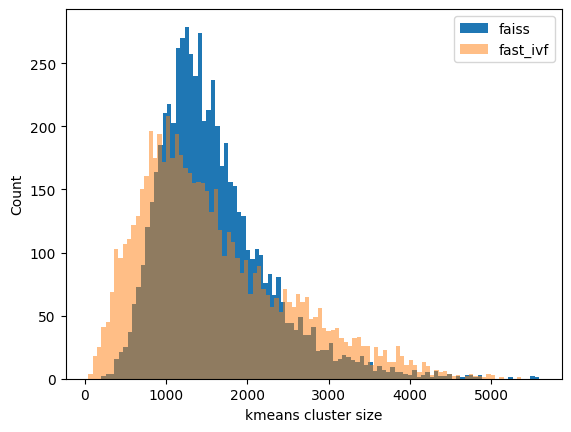

In [16]:
plt.hist(faiss_counts, 100, label="faiss");
_, fast_ivf_counts = np.unique(index.kmeans._labels, return_counts=True)
plt.hist(fast_ivf_counts, 100, label="fast_ivf", alpha=0.5);
plt.xlabel("kmeans cluster size")
plt.ylabel("Count")
plt.legend()

# Compressed IVF index

In [17]:
from fast_ivf import CompressedFastIVF

index = CompressedFastIVF(
    d,
    nlist=nlist,
    compression_ndim=32,
    compressor_steps_per_epoch=2000,
    kmeans_batch_size=1024,
    kmeans_max_steps=2000,
)
index.train(train_embeddings)

2023-11-01 09:30:08.698457: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-01 09:30:08.725717: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-01 09:30:09.748508: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-01 09:30:10.644150: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-11-01 09:30:10.644178: I tensorflow/compiler/xla/stream_executor/cuda/

Training compressor steps_per_epoch=2000 epoch=10 compression_ndim=32
Epoch 1/10
2000/2000 [==============================] - 12s 6ms/step - loss: 4.7292 - categorical_accuracy: 0.1538 - top_k_categorical_accuracy: 0.4931
Epoch 2/10
2000/2000 [==============================] - 11s 5ms/step - loss: 3.1741 - categorical_accuracy: 0.2751 - top_k_categorical_accuracy: 0.7442
Epoch 3/10
2000/2000 [==============================] - 8s 4ms/step - loss: 2.8862 - categorical_accuracy: 0.3142 - top_k_categorical_accuracy: 0.7991
Epoch 4/10
2000/2000 [==============================] - 9s 4ms/step - loss: 2.7500 - categorical_accuracy: 0.3349 - top_k_categorical_accuracy: 0.8231
Epoch 5/10
2000/2000 [==============================] - 10s 5ms/step - loss: 2.6764 - categorical_accuracy: 0.3457 - top_k_categorical_accuracy: 0.8346
Epoch 6/10
2000/2000 [==============================] - 12s 6ms/step - loss: 2.6174 - categorical_accuracy: 0.3561 - top_k_categorical_accuracy: 0.8456
Epoch 7/10
2000/2000

Adding compressed vectors: 9756it [00:04, 2015.02it/s]


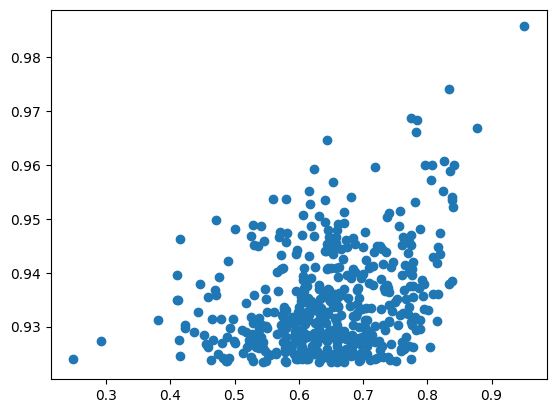

In [18]:
index.nprobe = 40
distances, indices = index.search(test_embeddings[:100], k=500, rescore=False)

idx = 1
query = test_embeddings[idx]
exact_distances = train_embeddings[indices[idx]] @ query

plt.scatter(exact_distances, distances[idx])

In [19]:
index.nprobe = 10
index.ratio_threshold = 0.5
index.rescore_num_samples = -1
distances, indices = index.search(test_embeddings, k=100)

accuracies = []
for i, qi in enumerate(indices):
    acc = exact_indices[i] in qi[:10]
    accuracies.append(acc)
np.mean(accuracies)

0.5919

In [20]:
%timeit index.search(test_embeddings, k=100)

1.15 s ± 33.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/krzysiek/DATA/GITHUB/fast-ivf/fast_ivf/core.py:41: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  indices = query_indices[i]


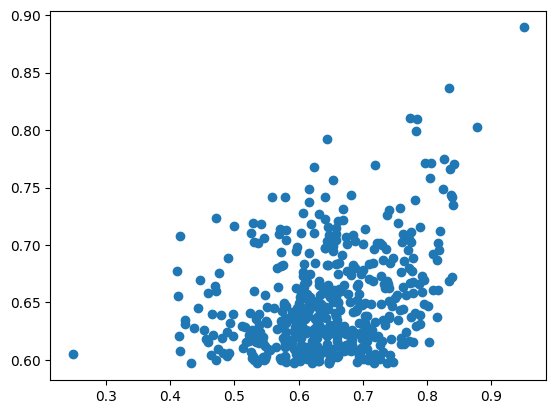

In [21]:
index.rescore_num_samples = 20
distances, indices = index.search(test_embeddings[:100], k=500, rescore=True)
idx = 1
query = test_embeddings[idx]
exact_distances = train_embeddings[indices[idx]] @ query
plt.scatter(exact_distances, distances[idx])

# FastIVFPQ

In [22]:
96 / 32, 2**6

(3.0, 64)

In [23]:
from fast_ivf import FastIVFPQ

index = FastIVFPQ(
    d,
    nlist=nlist,
    pq_num_subvectors=32,
    pq_num_centroids=64,
)
index.train(train_embeddings)

Convergence delta = 0.81673:   1%|          | 12/1000 [00:00<00:08, 112.14it/s]

Convergence delta = 0.00046: 100%|██████████| 1000/1000 [00:13<00:00, 75.69it/s]
Assigning: 9756it [00:42, 231.22it/s]                          
Convergence delta = 0.00071: 100%|██████████| 1000/1000 [00:03<00:00, 323.50it/s]
Assigning: 78047it [00:51, 1519.78it/s]                           


In [39]:
index.nprobe = 10
index.ratio_threshold = 0.5
distances, indices = index.search(test_embeddings, k=100)

accuracies = []
for i, qi in enumerate(indices):
    acc = exact_indices[i] in qi[:10]
    accuracies.append(acc)
np.mean(accuracies)

0.7611

In [25]:
%timeit index.search(test_embeddings, k=100, rescore=False)

2.41 s ± 19.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
m = 32
n_bits = 6 # 2 ** 6 = 64 centroids per subvector

faiss_index = faiss.IndexIVFPQ(faiss.IndexFlatIP(d), d, nlist, m, n_bits)
faiss_index.train(train_embeddings)
faiss_index.add(train_embeddings)

In [31]:
faiss_index.nprobe = 10
distances, indices = faiss_index.search(test_embeddings, 100)

accuracies = []
for i, qi in enumerate(indices):
    acc = exact_indices[i] in qi[:10]
    accuracies.append(acc)
np.mean(accuracies)

0.8703

In [32]:
%timeit faiss_index.search(test_embeddings, 100)

10.4 s ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
